In [2]:
import pylab as plt
import tqdm as tqdm
import pandas as pd
from herbie import FastHerbie
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import warnings
import pyproj
import matplotlib.patches as patches
warnings.filterwarnings('ignore')
import pickle

In [4]:
def uv_to_earth_old(lon, lat, proj, u, v):
    
    m = proj.get_factors(lon, lat)
    
    dy_dphi = m.dy_dphi
    dy_dlam = m.dy_dlam

    alpha = -np.arctan2(-np.cos(np.deg2rad(lat)) * np.deg2rad((1.0/dy_dlam)),np.deg2rad((1.0/dy_dphi)))
    
    return u * np.cos(alpha) - v * np.sin(alpha), v * np.cos(alpha) + u * np.sin(alpha)


def uv_to_grid_old(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)
    
    dy_dphi = m.dy_dphi
    dy_dlam = m.dy_dlam

    alpha = np.arctan2(-np.cos(np.deg2rad(lat)) * np.deg2rad((1.0/dy_dlam)),np.deg2rad((1.0/dy_dphi)))
    
    return u * np.cos(alpha) - v * np.sin(alpha), v * np.cos(alpha) + u * np.sin(alpha)

In [5]:
def uv_to_earth_new(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)

    dy_dphi = m.dy_dphi
    dy_dlam = m.dy_dlam

    # alpha = -np.arctan2(-np.cos(np.deg2rad(lat)) * (1.0 / dy_dlam), (1.0 / dy_dphi))
    alpha = np.arctan2(dy_dlam/np.cos(np.deg2rad(lat)), dy_dphi)

    return (
        u * np.cos(alpha) + v * np.sin(alpha),
        v * np.cos(alpha) - u * np.sin(alpha),
        alpha,
    )


def uv_to_grid_new(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)

    dy_dphi = m.dy_dphi
    dy_dlam = m.dy_dlam

    alpha = - np.arctan2(dy_dlam/np.cos(np.deg2rad(lat)), dy_dphi)

    return (
        u * np.cos(alpha) + v * np.sin(alpha),
        v * np.cos(alpha) - u * np.sin(alpha),
        alpha,
    )

In [3]:
def uv_to_earth_kyle(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)

    dy_dlam = m.dy_dlam
    dx_dlam = m.dx_dlam

    theta = -np.arctan2(dy_dlam, dx_dlam)

    return (
        u * np.cos(theta) - v * np.sin(theta),
        u * np.sin(theta) + v * np.cos(theta),
        theta,
    )


def uv_to_grid_kyle(lon, lat, proj, u, v):
    m = proj.get_factors(lon, lat)

    dy_dlam = m.dy_dlam
    dx_dlam = m.dx_dlam

    theta = np.arctan2(dy_dlam, dx_dlam)

    return (
        u * np.cos(theta) - v * np.sin(theta),
        u * np.sin(theta) + v * np.cos(theta),
        theta,
    )

In [7]:
"""
--- This is from the HRRR FAQ webpage at https://rapidrefresh.noaa.gov/faq/HRRR.faq.html.

PARAMETER ( ROTCON_P = 0.622515 )
PARAMETER ( LON_XX_P = -97.5 )
PARAMETER ( LAT_TAN_P = 38.5 )
C** ROTCON_P R WIND ROTATION CONSTANT, = 1 FOR POLAR STEREO
C** AND SIN(LAT_TAN_P) FOR LAMBERT CONFORMAL
C** LON_XX_P R MERIDIAN ALIGNED WITH CARTESIAN X-AXIS(DEG)
C** LAT_TAN_P R LATITUDE AT LAMBERT CONFORMAL PROJECTION
C** IS TRUE (DEG)
do j=1,ny_p
do i=1,nx_p
angle2 = rotcon_p*(olon(i,j)-lon_xx_p)*0.017453
sinx2 = sin(angle2)
cosx2 = cos(angle2)
do k=1,nzp_p
ut = u(i,j,k)
vt = v(i,j,k)
un(i,j,k) = cosx2*ut+sinx2*vt
vn(i,j,k) =-sinx2*ut+cosx2*vt
end do
end do
end do

--- NOTE: In "angle2 = rotcon_p*(olon(i,j)-lon_xx_p)*0.017453", 0.017453 = pi/2.
"""


def uv_to_earth_noaa(lon, u, v):
    rlon = -97.5
    rlat = 38.5
    rotcon_p = np.sin(np.deg2rad(rlat))

    alpha = rotcon_p * np.deg2rad(lon - rlon)

    return (
        np.cos(alpha) * u + np.sin(alpha) * v,
        -np.sin(alpha) * u + np.cos(alpha) * v,
        alpha,
    )

In [4]:
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)

In [5]:
crsproj_hrrr = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5],
                             globe=globe)
pyproj_hrrr = pyproj.Proj(crsproj_hrrr)

In [6]:
lat_center = 35.00
lon_center = -123.71
proj_lon_center = -68.0
crsproj_pinacles = ccrs.LambertConformal(central_longitude=proj_lon_center, central_latitude=lat_center,
                            standard_parallels=(lat_center, lat_center), globe=globe)
pyproj_pinacles = pyproj.Proj(crsproj_pinacles)

In [7]:
pc = ccrs.PlateCarree()

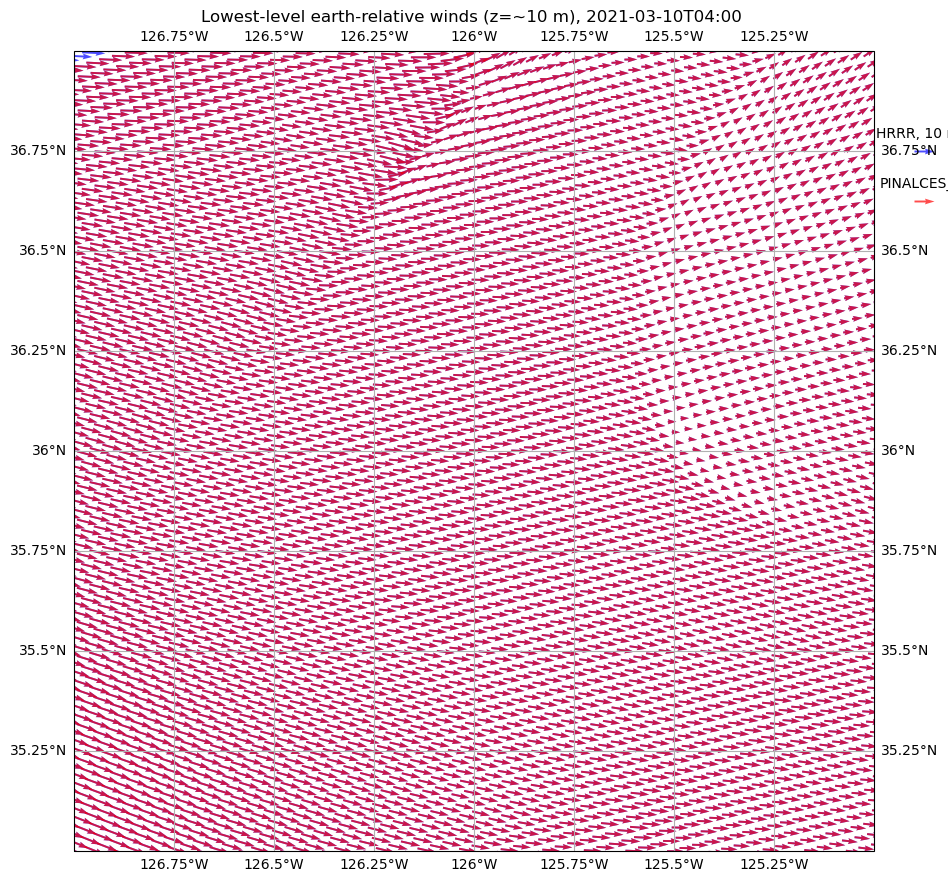

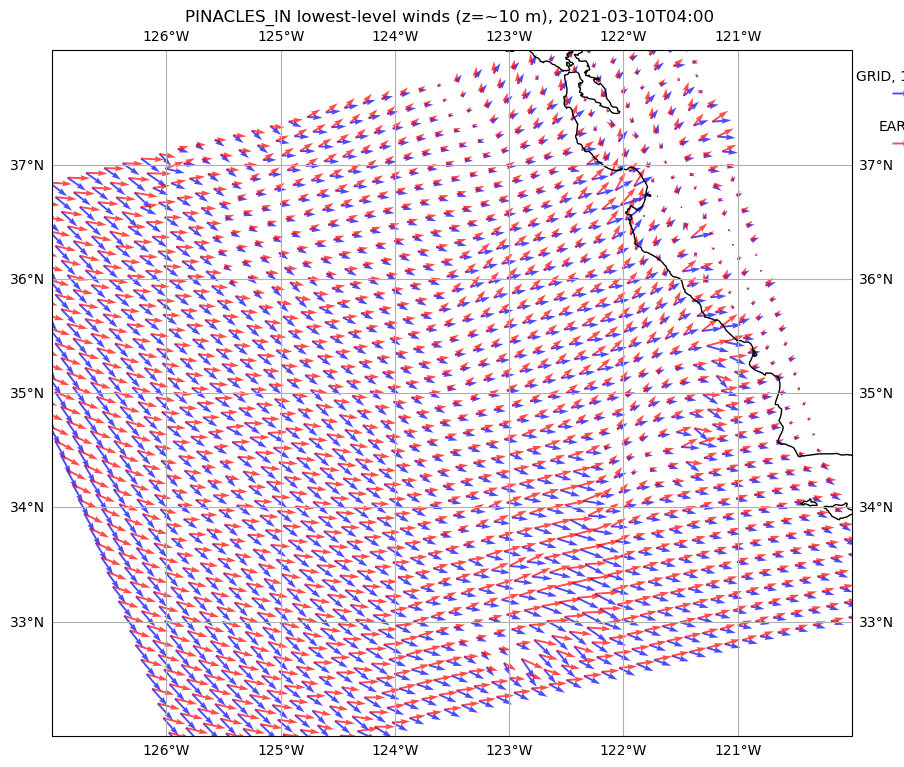

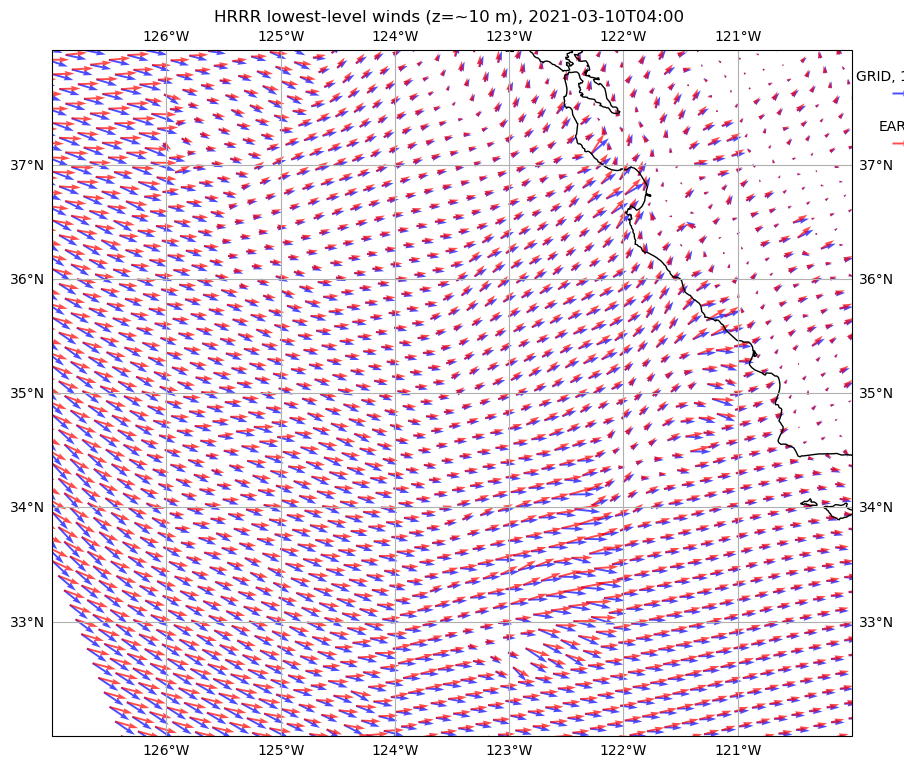

In [10]:
# valid_time to plot
vtime_to_plot = np.datetime64("2021-03-10T04:00")
time_to_plot = vtime_to_plot - np.timedelta64(1, 'h')
file_date = np.datetime_as_string(time_to_plot, unit='D')
file_date = f"{file_date[:4]}{file_date[5:7]}{file_date[8:10]}"
filename = f"/home/xiao169/lidarbuoy/hrrr/uv.{file_date}.grib2" 
ds_hrrr = xr.open_dataset(filename, engine='cfgrib')
lathrrr = ds_hrrr.latitude
lonhrrr = ((ds_hrrr.longitude + 180) % 360) - 180
nt_hrrr = np.where(ds_hrrr.valid_time == vtime_to_plot)[0][0]
nz_hrrr = 0 
uhrrr = ds_hrrr.u[nt_hrrr, nz_hrrr, :, :]
vhrrr = ds_hrrr.v[nt_hrrr, nz_hrrr, :, :]
uhrrr_ear, vhrrr_ear, alpha_hrrr = uv_to_earth_kyle(lonhrrr, lathrrr, pyproj_hrrr, uhrrr, vhrrr)
ds_pin = xr.open_dataset(f"/home/xiao169/lidarbuoy/pinacles_in/pinacles_in_21-03-08-00z_to_21-03-17-00z.nc")
nt_pin = np.where(ds_pin.valid_time == vtime_to_plot)[0][0]
nz_pin = 0
lat_pin = ds_pin.latitude
lon_pin = ds_pin.longitude
upin = ds_pin.U[nt_pin, nz_pin, :, :]
vpin = ds_pin.V[nt_pin, nz_pin, :, :]
upin_ear, vpin_ear, alpha_pin = uv_to_earth_kyle(lon_pin, lat_pin, pyproj_pinacles, upin, vpin)
fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
d = 20
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((-127, -125, 35, 37))
# ax.quiver(lon[::d,::d], lat[::d,::d], uear[::d, ::d], vear[::d,::d], color='blue', scale_units='dots', scale=0.5)
d = 1 
q1 = ax.quiver(lonhrrr[::d,::d], lathrrr[::d,::d], uhrrr_ear[::d,::d], vhrrr_ear[::d,::d], color='blue', scale_units='dots', scale=0.5, alpha=0.7)
q2 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], upin_ear[::d,::d], vpin_ear[::d,::d], color='red', scale_units='dots', scale=0.5, alpha=0.7)
ax.set_title(f'Lowest-level earth-relative winds (z=~10 m), {vtime_to_plot} ')
ax.quiverkey(q1, 0.9, 0.75, 10, label='HRRR, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='PINALCES_IN', color='red',coordinates='figure')
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
d = 20
ax.set_extent((-127, -120, 32, 38))
# ax.set_extent((-127, -125, 35, 37))
# ax.quiver(lon[::d,::d], lat[::d,::d], uear[::d, ::d], vear[::d,::d], color='blue', scale_units='dots', scale=0.5)
d = 5
q1 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], upin[::d,::d], vpin[::d,::d], color='blue', scale_units='dots', scale=0.5, alpha=0.7)
q2 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], upin_ear[::d,::d], vpin_ear[::d,::d], color='red', scale_units='dots', scale=0.5, alpha=0.7)
ax.set_title(f'PINACLES_IN lowest-level winds (z=~10 m), {vtime_to_plot} ')
ax.quiverkey(q1, 0.9, 0.75, 10, label='GRID, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='EARTH', color='red',coordinates='figure')
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
d = 20
ax.set_extent((-127, -120, 32, 38))
# ax.set_extent((-127, -125, 35, 37))
# ax.quiver(lon[::d,::d], lat[::d,::d], uear[::d, ::d], vear[::d,::d], color='blue', scale_units='dots', scale=0.5)
d = 5
q1 = ax.quiver(lonhrrr[::d,::d], lathrrr[::d,::d], uhrrr[::d,::d], vhrrr[::d,::d], color='blue', scale_units='dots', scale=0.5, alpha=0.7)
q2 = ax.quiver(lonhrrr[::d,::d], lathrrr[::d,::d], uhrrr_ear[::d,::d], vhrrr_ear[::d,::d], color='red', scale_units='dots', scale=0.5, alpha=0.7)
ax.set_title(f'HRRR lowest-level winds (z=~10 m), {vtime_to_plot} ')
ax.quiverkey(q1, 0.9, 0.75, 10, label='GRID, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='EARTH', color='red',coordinates='figure')
plt.show()

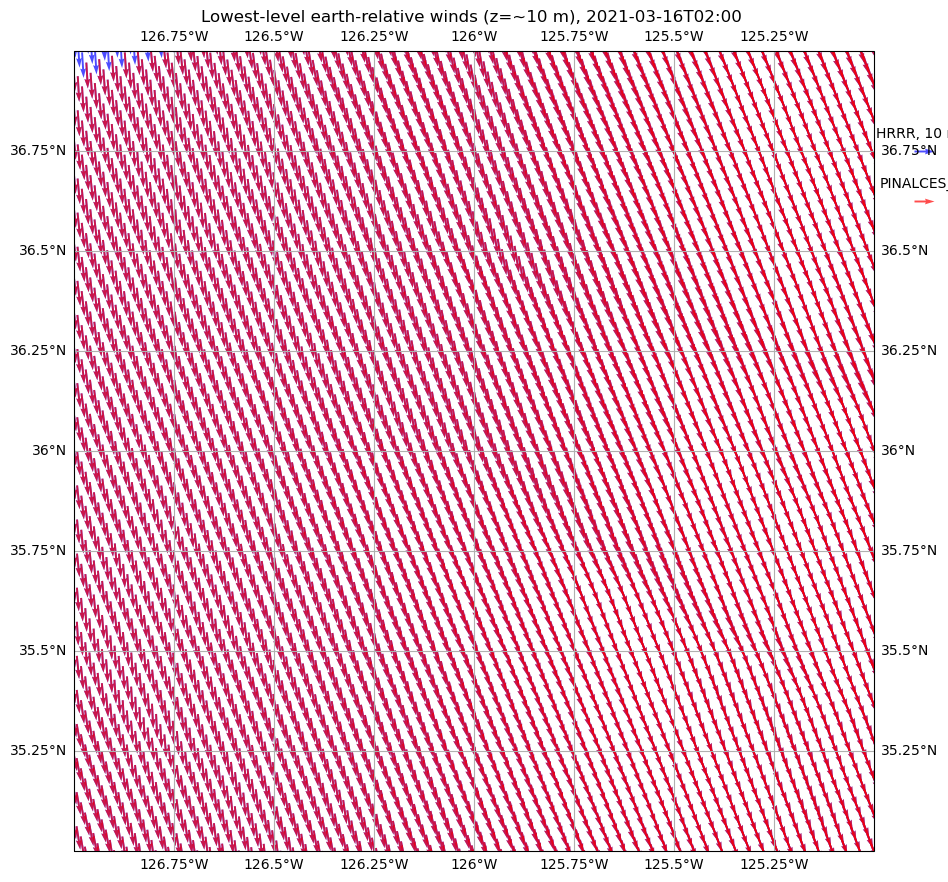

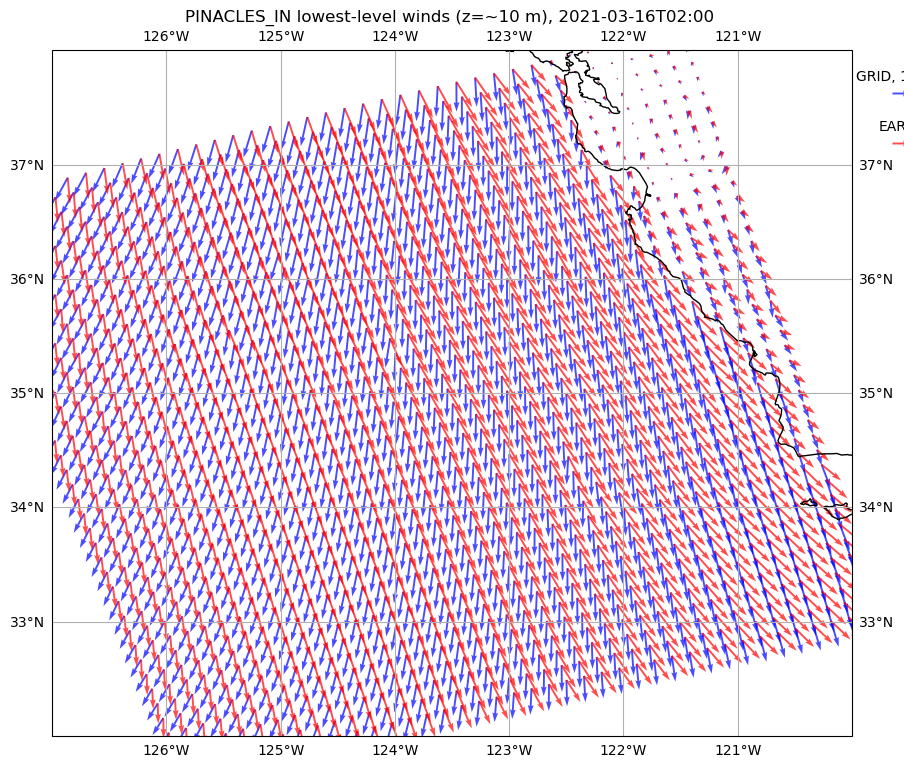

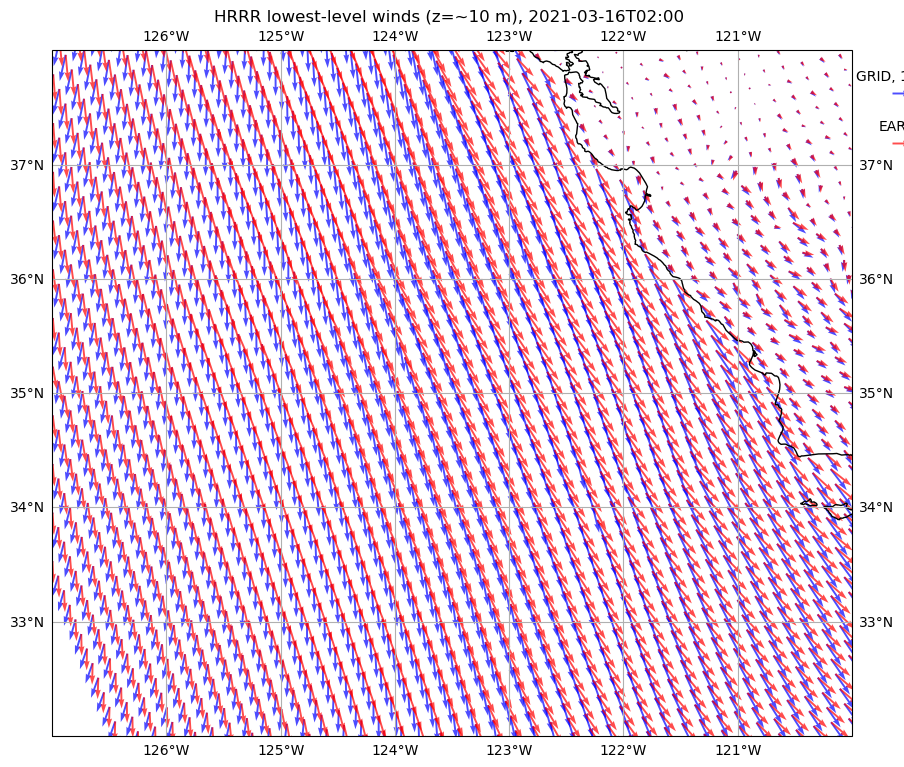

In [11]:
# valid_time to plot
vtime_to_plot = np.datetime64("2021-03-16T02:00")
time_to_plot = vtime_to_plot - np.timedelta64(1, 'h')
file_date = np.datetime_as_string(time_to_plot, unit='D')
file_date = f"{file_date[:4]}{file_date[5:7]}{file_date[8:10]}"
filename = f"/home/xiao169/lidarbuoy/hrrr/uv.{file_date}.grib2" 
ds_hrrr = xr.open_dataset(filename, engine='cfgrib')
lathrrr = ds_hrrr.latitude
lonhrrr = ((ds_hrrr.longitude + 180) % 360) - 180
nt_hrrr = np.where(ds_hrrr.valid_time == vtime_to_plot)[0][0]
nz_hrrr = 0 
uhrrr = ds_hrrr.u[nt_hrrr, nz_hrrr, :, :]
vhrrr = ds_hrrr.v[nt_hrrr, nz_hrrr, :, :]
uhrrr_ear, vhrrr_ear, alpha_hrrr = uv_to_earth_kyle(lonhrrr, lathrrr, pyproj_hrrr, uhrrr, vhrrr)
ds_pin = xr.open_dataset(f"/home/xiao169/lidarbuoy/pinacles_in/pinacles_in_21-03-08-00z_to_21-03-17-00z.nc")
nt_pin = np.where(ds_pin.valid_time == vtime_to_plot)[0][0]
nz_pin = 0
lat_pin = ds_pin.latitude
lon_pin = ds_pin.longitude
upin = ds_pin.U[nt_pin, nz_pin, :, :]
vpin = ds_pin.V[nt_pin, nz_pin, :, :]
upin_ear, vpin_ear, alpha_pin = uv_to_earth_kyle(lon_pin, lat_pin, pyproj_pinacles, upin, vpin)
fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
d = 20
# ax.set_extent((-127, -120, 32, 38))
ax.set_extent((-127, -125, 35, 37))
# ax.quiver(lon[::d,::d], lat[::d,::d], uear[::d, ::d], vear[::d,::d], color='blue', scale_units='dots', scale=0.5)
d = 1 
q1 = ax.quiver(lonhrrr[::d,::d], lathrrr[::d,::d], uhrrr_ear[::d,::d], vhrrr_ear[::d,::d], color='blue', scale_units='dots', scale=0.5, alpha=0.7)
q2 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], upin_ear[::d,::d], vpin_ear[::d,::d], color='red', scale_units='dots', scale=0.5, alpha=0.7)
ax.set_title(f'Lowest-level earth-relative winds (z=~10 m), {vtime_to_plot} ')
ax.quiverkey(q1, 0.9, 0.75, 10, label='HRRR, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='PINALCES_IN', color='red',coordinates='figure')
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
d = 20
ax.set_extent((-127, -120, 32, 38))
# ax.set_extent((-127, -125, 35, 37))
# ax.quiver(lon[::d,::d], lat[::d,::d], uear[::d, ::d], vear[::d,::d], color='blue', scale_units='dots', scale=0.5)
d = 5
q1 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], upin[::d,::d], vpin[::d,::d], color='blue', scale_units='dots', scale=0.5, alpha=0.7)
q2 = ax.quiver(lon_pin[::d,::d], lat_pin[::d,::d], upin_ear[::d,::d], vpin_ear[::d,::d], color='red', scale_units='dots', scale=0.5, alpha=0.7)
ax.set_title(f'PINACLES_IN lowest-level winds (z=~10 m), {vtime_to_plot} ')
ax.quiverkey(q1, 0.9, 0.75, 10, label='GRID, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='EARTH', color='red',coordinates='figure')
plt.show()

fig=plt.figure(figsize=(10,10))
ax = fig.add_axes((0.05, 0.05, 0.8, 0.8), projection=pc)
ax.coastlines()
gl=ax.gridlines(draw_labels=True)
d = 20
ax.set_extent((-127, -120, 32, 38))
# ax.set_extent((-127, -125, 35, 37))
# ax.quiver(lon[::d,::d], lat[::d,::d], uear[::d, ::d], vear[::d,::d], color='blue', scale_units='dots', scale=0.5)
d = 5
q1 = ax.quiver(lonhrrr[::d,::d], lathrrr[::d,::d], uhrrr[::d,::d], vhrrr[::d,::d], color='blue', scale_units='dots', scale=0.5, alpha=0.7)
q2 = ax.quiver(lonhrrr[::d,::d], lathrrr[::d,::d], uhrrr_ear[::d,::d], vhrrr_ear[::d,::d], color='red', scale_units='dots', scale=0.5, alpha=0.7)
ax.set_title(f'HRRR lowest-level winds (z=~10 m), {vtime_to_plot} ')
ax.quiverkey(q1, 0.9, 0.75, 10, label='GRID, 10 m/s', color='blue',coordinates='figure')
ax.quiverkey(q2, 0.9, 0.7, 10, label='EARTH', color='red',coordinates='figure')
plt.show()